In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
data = pd.read_csv("final_data.csv")
data.head()

,Unnamed: 0,review
0,0,Yet another complaint about HP Smart Printer software. It's not fit for purpose. I've wasted days going around in circles with a printer that refuses to enable printing services until it is acti...
1,1,"HP MFP 4101fdwe DO NOT PURCHASEThis product does not connect to the HP Smart app, does not connect to the internet, and customer support has hung up on me over 10 times without answering my calls...."
2,2,2 Broken printers from manifacture. 5 hours of time wasted. The only offer refurbished printers to replace an existing one even if its a week old. Instant ink is also very poor.Sends a new one bef...
3,3,"Following up from my last review, case was accelerated. Contacted by customer service who were incredible. Great outcome despite the stressful days of trying to sort out my issue. New cartridge s..."
4,4,"I have bought onsite support. My laptop will not start so I contacted HP support. They ordered a UPS pick-up, not onsite support. UPS arrived but did not have the collection box. They said they wo..."


In [3]:
data.rename( columns={'Unnamed: 0':'Id'}, inplace=True )
data.head()

,Id,review
0,0,Yet another complaint about HP Smart Printer software. It's not fit for purpose. I've wasted days going around in circles with a printer that refuses to enable printing services until it is acti...
1,1,"HP MFP 4101fdwe DO NOT PURCHASEThis product does not connect to the HP Smart app, does not connect to the internet, and customer support has hung up on me over 10 times without answering my calls...."
2,2,2 Broken printers from manifacture. 5 hours of time wasted. The only offer refurbished printers to replace an existing one even if its a week old. Instant ink is also very poor.Sends a new one bef...
3,3,"Following up from my last review, case was accelerated. Contacted by customer service who were incredible. Great outcome despite the stressful days of trying to sort out my issue. New cartridge s..."
4,4,"I have bought onsite support. My laptop will not start so I contacted HP support. They ordered a UPS pick-up, not onsite support. UPS arrived but did not have the collection box. They said they wo..."


In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import nltk
nltk.downloader.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
sia.polarity_scores('i am happy')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [5]:
result= {}
for i, row in tqdm(data.iterrows(), total=len(data)):
  text = row['review']
  myid = row['Id']
  result[myid] = sia.polarity_scores(text)

vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(data, how='left')
exp = vaders.head()
exp

  0%|          | 0/632 [00:00<?, ?it/s]

,Id,neg,neu,pos,compound,review
0,0,0.078,0.862,0.060,-0.2737,Yet another complaint about HP Smart Printer software. It's not fit for purpose. I've wasted days going around in circles with a printer that refuses to enable printing services until it is acti...
1,1,0.027,0.851,0.122,0.6955,"HP MFP 4101fdwe DO NOT PURCHASEThis product does not connect to the HP Smart app, does not connect to the internet, and customer support has hung up on me over 10 times without answering my calls...."
2,2,0.120,0.880,0.000,-0.7430,2 Broken printers from manifacture. 5 hours of time wasted. The only offer refurbished printers to replace an existing one even if its a week old. Instant ink is also very poor.Sends a new one bef...
3,3,0.000,0.780,0.220,0.8520,"Following up from my last review, case was accelerated. Contacted by customer service who were incredible. Great outcome despite the stressful days of trying to sort out my issue. New cartridge s..."
4,4,0.119,0.753,0.129,0.0000,"I have bought onsite support. My laptop will not start so I contacted HP support. They ordered a UPS pick-up, not onsite support. UPS arrived but did not have the collection box. They said they wo..."


In [6]:
import string 
string.punctuation
punc = string.punctuation
def remove_punc(text):
  return text.translate(str.maketrans('', '', punc)) 
data['review']=data['review'].apply(remove_punc)

import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stopwords.words('english'))

def remove_stopwords(text):
  new_text =[]

  for word in text.split():
    if word in stopwords.words('english'):
      new_text.append('')
    else:
      new_text.append(word)
  x = new_text[:]
  new_text.clear()
  return " ".join(x)

  data['review']=data['review'].apply(remove_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
import nltk
nltk.download('punkt')
import re
from nltk.tokenize import word_tokenize, sent_tokenize
def token(text):
  final = word_tokenize(text) 
  filtered_sentence = [w for w in final if not w.lower() in stop_words]
  filtered_sentence = []

  for w in final:
      if w not in stop_words:
          filtered_sentence.append(w)
  return(" ".join(filtered_sentence))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.0 MB/s eta 0:00:00


In [9]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.7 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=b9bfbbc3a5bb170e1c1c2f9db9db171fba259353759a45e5ee678493ce5c4fe8
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [10]:

import re
from cleantext import clean
import contractions
import string
def clean_Text(sampleText):
    sampleText=sampleText.lower().replace("_", " ").replace("-", " ").translate(str.maketrans('', '', string.punctuation))
    sampleText=clean(sampleText, no_emoji=True)
    return (contractions.fix(sampleText))

In [11]:
title_clean=[]
for x in data.review:
    try:
        title_clean.append(token(clean_Text(x)))
    except:
        title_clean.append(np.nan)
    
data['token_review']=data['review'].apply(lambda x: token(x.lower()))


In [12]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemm(text):
  for word in text:
    return lemmatizer.lemmatize(text)

nltk.download('wordnet')
data['token_review_lemm']=title_clean

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
data['token_review']=data['review'].apply(lemm)
data.head()

,Id,review,token_review,token_review_lemm
0,0,Yet another complaint about HP Smart Printer software Its not fit for purpose Ive wasted days going around in circles with a printer that refuses to enable printing services until it is activate...,Yet another complaint about HP Smart Printer software Its not fit for purpose Ive wasted days going around in circles with a printer that refuses to enable printing services until it is activate...,yet another complaint hp smart printer software fit purpose wasted days going around circles printer refuses enable printing services activated however obtain pairing code activate iteventually go...
1,1,HP MFP 4101fdwe DO NOT PURCHASEThis product does not connect to the HP Smart app does not connect to the internet and customer support has hung up on me over 10 times without answering my calls E...,HP MFP 4101fdwe DO NOT PURCHASEThis product does not connect to the HP Smart app does not connect to the internet and customer support has hung up on me over 10 times without answering my calls E...,hp mfp 4101fdwe purchasethis product connect hp smart app connect internet customer support hung 10 times without answering calls edit someone called back spoke hour solve problem offer potential ...
2,2,2 Broken printers from manifacture 5 hours of time wasted The only offer refurbished printers to replace an existing one even if its a week old Instant ink is also very poorSends a new one before ...,2 Broken printers from manifacture 5 hours of time wasted The only offer refurbished printers to replace an existing one even if its a week old Instant ink is also very poorSends a new one before ...,2 broken printers manifacture 5 hours time wasted offer refurbished printers replace existing one even week old instant ink also poorsends new one old depleted could half full aweful experieance c...
3,3,Following up from my last review case was accelerated Contacted by customer service who were incredible Great outcome despite the stressful days of trying to sort out my issue New cartridge sent ...,Following up from my last review case was accelerated Contacted by customer service who were incredible Great outcome despite the stressful days of trying to sort out my issue New cartridge sent ...,following last review case accelerated contacted customer service incredible great outcome despite stressful days trying sort issue new cartridge sent arrived thank
4,4,I have bought onsite support My laptop will not start so I contacted HP support They ordered a UPS pickup not onsite support UPS arrived but did not have the collection box They said they would be...,I have bought onsite support My laptop will not start so I contacted HP support They ordered a UPS pickup not onsite support UPS arrived but did not have the collection box They said they would be...,bought onsite support laptop start contacted hp support ordered ups pickup onsite support ups arrived collection box said would back 2 working days later ups since tried every option available hp ...


In [14]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
        ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################
  return [ent1.strip(), ent2.strip()]

In [15]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [16]:
entity_pairs = []

for i in tqdm(data["token_review_lemm"]):
  entity_pairs.append(get_entities(i))

  0%|          | 0/632 [00:00<?, ?it/s]

In [17]:
entity_pairs[10:20]

[['people', 'hp'],
 ['fishy  business', 'hp customer care'],
 ['free ink life printer', 'repeatedly  yuk'],
 ['iron shirts', 'personal business use'],
 ['laptoppc  issues', 'hour wait folks'],
 ['people', 'ink'],
 ['moreover  shift', 'single  issue'],
 ['used relation printer', 'money bunch'],
 ['different company problem', '24  hours'],
 ['subscriptionnext  connection', 'failing  printer']]

In [21]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [23]:
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target})

In [24]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", create_using=nx.MultiDiGraph())


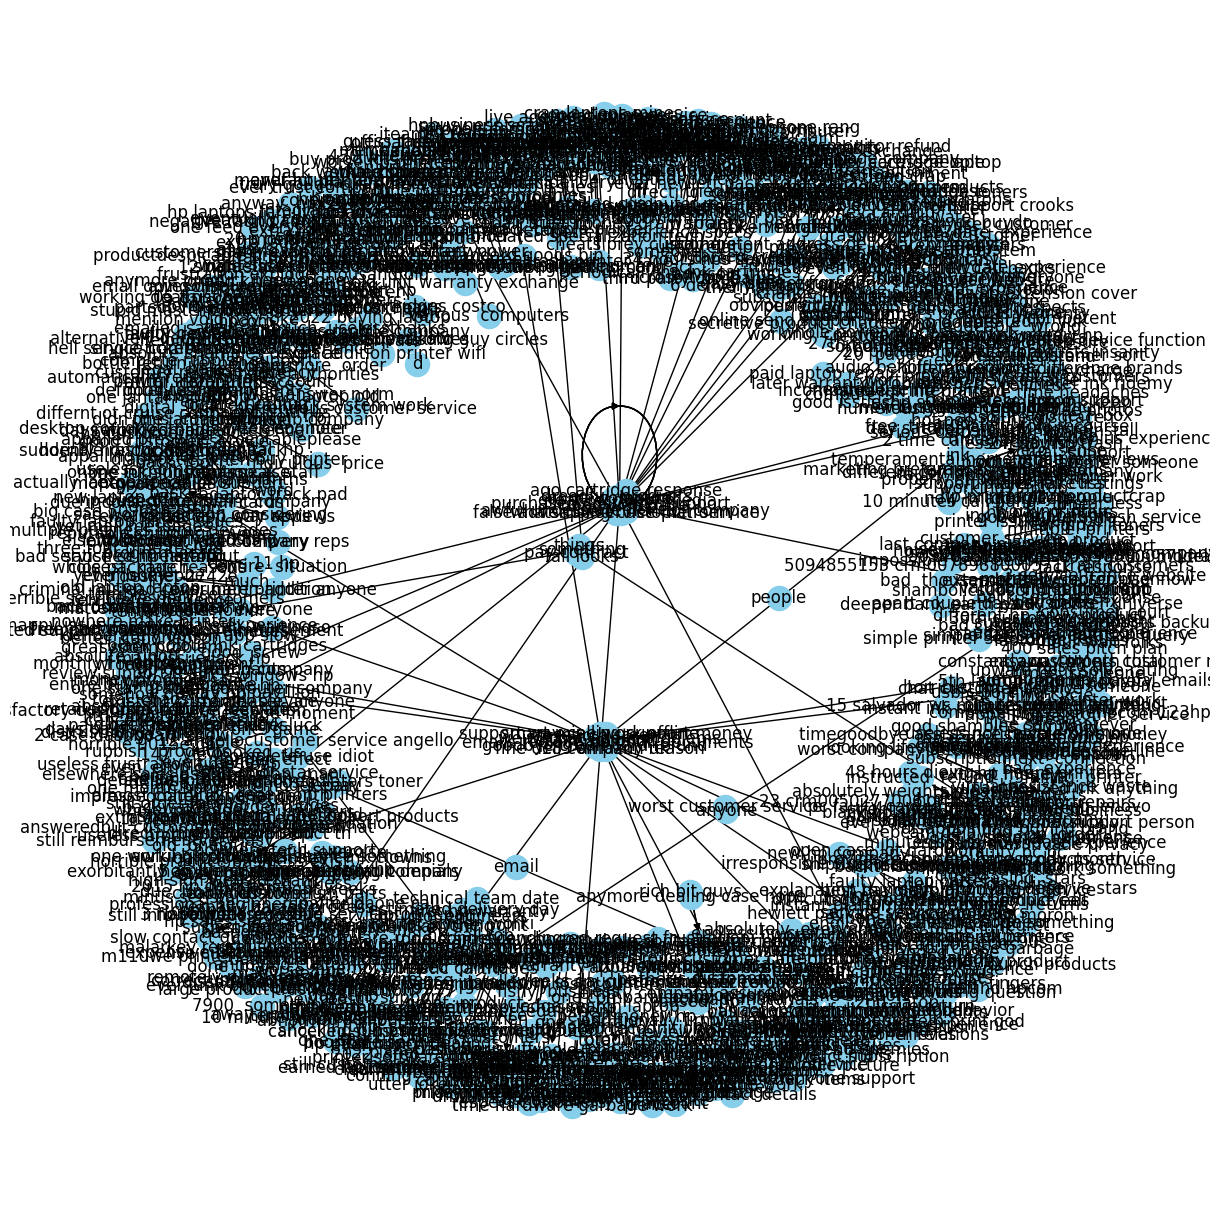

In [25]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

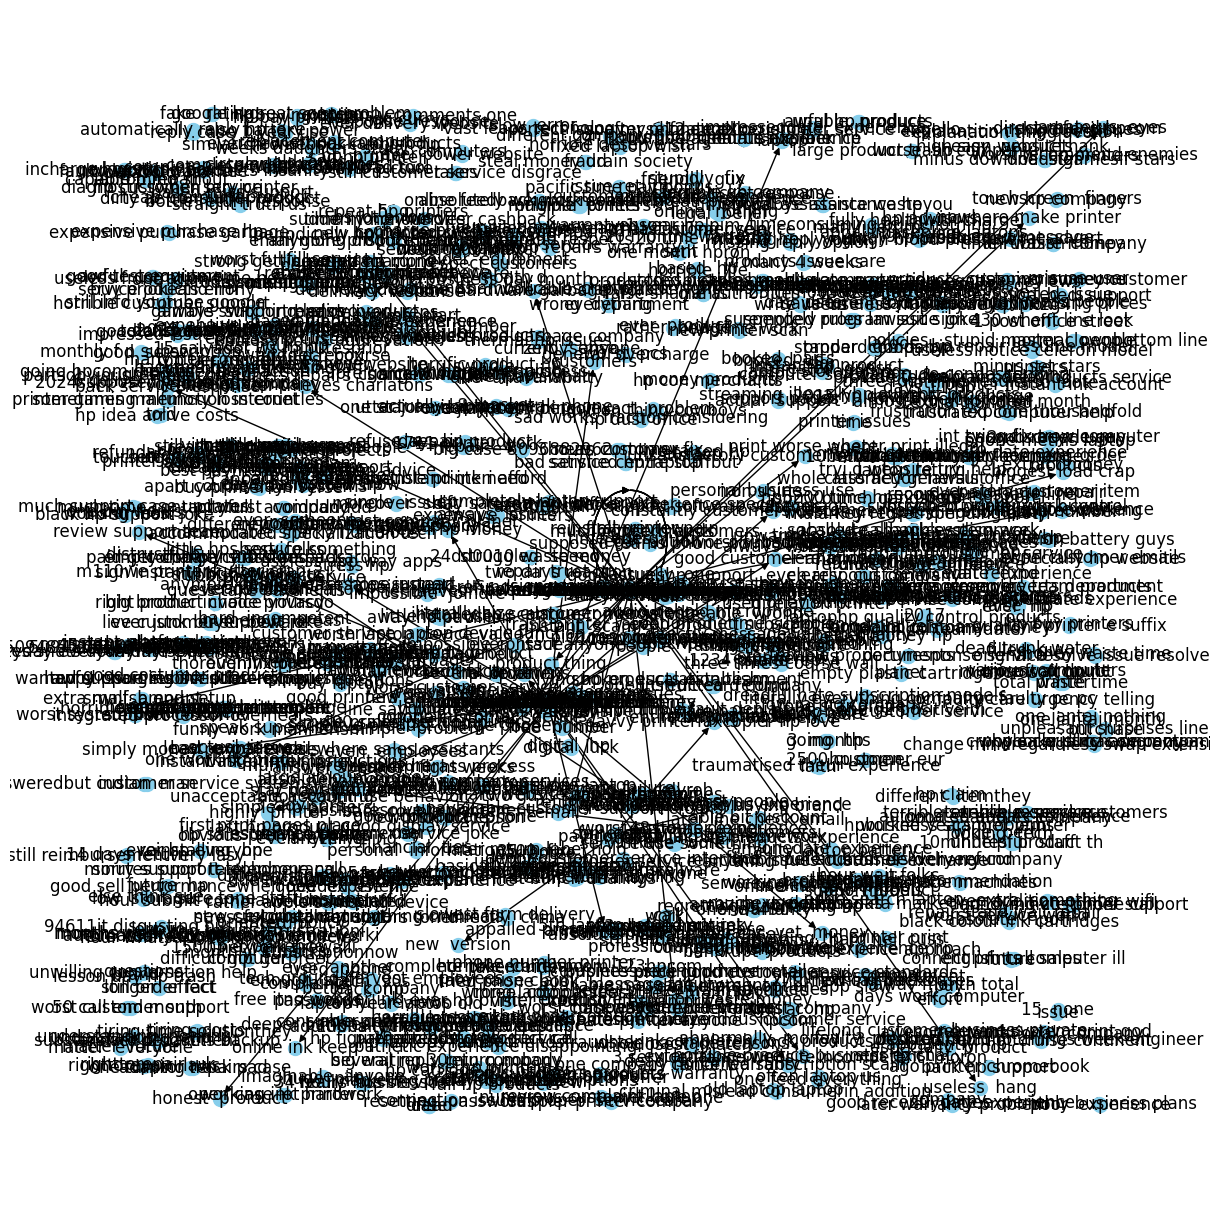

In [26]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.000001)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=100, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()